# library used

- Primary pyhton library like pandas and numpy are used. 
- re library is used to make it easier to process columns and reduce redundant works. 
- json is imported to rename columns and read metadata from json files. 
- seaborn library is used to do line regression modelling. 
- sklearn library is imported as it is required for principle coordinates analysis and K-mean clustering. 
- matplotlib library is required for graph plotting.


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as df

import re
import matplotlib.pyplot as plt
import json

from collections import defaultdict
import seaborn as sns

from pandas.plotting import parallel_coordinates as pc_plot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

from sklearn.cluster import KMeans

# read data

## rename columns function

### get_title_from_json()

- read json file and get title to replace

In [2]:
from pprint import pprint

def get_title_from_json(file):
    with open(file) as title_file:
        title = json.load(title_file)[ 'selectedAttributes']
        
        res = {}
        
        # replace unwanted character
        for dict_title in title:
            res[dict_title['name']] = dict_title['title'].replace("- ", "").replace(" ", "_")
    return res

### rename_columns()

- replace each column in a df()

In [3]:
def rename_columns(file, table, strip=[' ']):
    title = get_title_from_json(file)
    # remove space in columns
    for item in strip[0]:
        renamed = table.rename(columns=lambda x: x.replace(item, ''))
    # reneme columns
    renamed = renamed.rename(columns=title)
    # remove extra space
    if len(strip) > 1:
        for item in strip[1]:
            renamed = table.rename(columns=lambda x: x.replace(item, ''))
    return renamed

## read data

- read .csv file by pd.read_csv()
- more about content in data set see read me file

In [4]:
disease = pd.read_csv("LGA11_Chronic_Disease_-_Modelled_Estimate.csv")

In [5]:
lga_profile = pd.read_csv("Local_Government_Area__LGA__profiles_data_2011.csv")

In [6]:
adualt_health_risk = pd.read_csv("LGA11_Health_Risk_Factors_-_Modelled_Estimate.csv")

In [7]:
psychological_distress = pd.read_csv("LGA11_Psychological_Distress_-_Modelled_Estimate.csv")

## rename columns

- read .json file and replace column name in each pd.df()

In [8]:
disease = rename_columns("LGA11_Chronic_Disease_-_Modelled_Estimate.json", disease)

In [9]:
lga_profile = rename_columns("Local_Government_Area__LGA__profiles_data_2011.json", lga_profile)

In [10]:
adualt_health_risk = rename_columns("LGA11_Health_Risk_Factors_-_Modelled_Estimate.json", adualt_health_risk)

In [11]:
psychological_distress = rename_columns("LGA11_Psychological_Distress_-_Modelled_Estimate.json", psychological_distress)

# preprocessing data

In [12]:
lga_name = disease["Local_Government_Area_Name"]
lga_code = disease["Local_Government_Area_Code"]

## drop unwanted rows

- some rows are not local government area so they needed to be dropped

In [13]:
disease = disease.iloc[:-1, :]

In [14]:
adualt_health_risk = adualt_health_risk.iloc[:-1, :]

In [15]:
psychological_distress = psychological_distress.iloc[:-1, :]

## drop unwanted data

### disease risk drop

- drop disease with "xxx_RRMSE" == 1

In [16]:
reg = re.compile("([a-zA-Z\_]+)_RRMSE")
disease_trust_selected = []

for index, col in enumerate(disease.columns):
    matched = re.match(reg, col)
    if matched != None:
        disease_trust_selected.append((matched.group(1), col))

In [17]:
# disease_trust_selected

In [18]:
for disease_name, col in disease_trust_selected:
#     print(col)
    disease = disease[disease[col] != 1]

In [19]:
disease.shape

(56, 26)

### health risk drop

- drop health risk with "xxx_RRMSE" == 1

In [20]:
reg = re.compile("([a-zA-Z\_\d+]+)\_RRMSE")
health_risk_trust_selected = []

for index, col in enumerate(adualt_health_risk.columns):
    matched = re.match(reg, col)
    if matched != None:
        health_risk_trust_selected.append((matched.group(0), col))

In [21]:
# health_risk_trust_selected

In [22]:
for risk_name, col in health_risk_trust_selected:
#     print(col)
    adualt_health_risk = adualt_health_risk[adualt_health_risk[col] != 1]

In [23]:
adualt_health_risk.shape

(67, 22)

### psychological stress drop

- drop disease with "xxx_RRMSE" == 1

In [24]:
psychological_distress = psychological_distress[psychological_distress["High_or_Very_High_Psychological_Distress_Levels_(K-10)_RRMSE"] != 1]

In [25]:
psychological_distress.shape

(78, 4)

## split to df()

### disease risk (percentage) - normalize

- select columns

In [26]:
reg = re.compile("([a-zA-Z\_]+)_Rate_per_100")
disease_selected = []

for index, col in enumerate(disease.columns):
#     print(index, col)
    matched = re.match(reg, col)
    if matched != None:
        disease_selected.append((matched.group(1), col))

In [27]:
# disease_selected

- normalize data

In [28]:
disease_risk = df()
disease_risk['Local_Government_Area_Code'] = disease['Local_Government_Area_Code']

for illness, col in disease_selected:
    disease_risk[illness] = disease[col] / 100

### health_risk (percentage) - normalize

In [29]:
health_risk = df()

- select columns

In [30]:
reg = re.compile("([a-zA-Z\_\d+]+)\_Rate\_per\_100")
health_risk_selected = []

for index, col in enumerate(adualt_health_risk.columns):
#     print(index, col)
    matched = re.match(reg, col)
    if matched != None:
        health_risk_selected.append((matched.group(1), col))

- normalize

In [31]:
health_risk = df()
health_risk['Local_Government_Area_Code'] = adualt_health_risk['Local_Government_Area_Code']

for risk_life_style, col in health_risk_selected:
    health_risk[risk_life_style] = adualt_health_risk[col] / 100

In [32]:
health_risk['High_or_Very_High_Psychological_Distress_Levels_(K-10)'] = psychological_distress['High_or_Very_High_Psychological_Distress_Levels_(K-10)_Rate_per_100'] / 100

In [33]:
health_risk['GP_attendances_females'] = lga_profile['GP_attendances_females_per_1000_population'] / 1000
health_risk['GP_attendances_males'] = lga_profile['GP_attendances_males_per_1000_population'] / 1000
health_risk['GP_attendances_total'] = lga_profile['GP_attendances_total_per_1000_population'] / 1000

In [34]:
health_risk['population_with_membership_of_organised_groups'] = lga_profile['%_of_population_with_membership_of_organised_groups'] / 100
health_risk['population_with_food_insecurity'] = lga_profile['%_population_with_food_insecurity'] / 100
health_risk['population_with_private_health_insurance'] = lga_profile['%_population_with_private_health_insurance'] / 100
health_risk['persons_that_did_not_meet_fruit_and_vegetable_guidelines'] = lga_profile['%_persons_that_did_not_meet_fruit_and_vegetable_guidelines'] / 100
health_risk['persons_who_did_not_meet_physical_activity_guidelines'] = lga_profile['%_persons_who_did_not_meet_physical_activity_guidelines'] / 100

### split by area

- divide to lga name, lga government type

In [35]:
local_governement = df()
local_governement["Local_Government_Area_Name"] = lga_name
local_governement["name"] = ""
local_governement["type"] = ""
local_governement["Local_Government_Area_Code"] = lga_code

reg = re.compile("([A-Za-z\s-]*)[\s]*(\([A-Z]*\))")
lga_group = defaultdict(int)

for index, lga in enumerate(local_governement["Local_Government_Area_Name"]):
    matched = re.match(reg, lga)
    if matched != None:
        lga_group[matched.group(2)] += 1
        local_governement.loc[index, "name"] = matched.group(1)
        local_governement.loc[index, "type"] = matched.group(2)

In [36]:
lga_group

defaultdict(int, {'(B)': 1, '(C)': 32, '(RC)': 7, '(S)': 39})

# initial correlation investigation

## disease_risk & health_risk

In [37]:
disease_health_risk_merged = disease_risk.merge(right=health_risk, left_on='Local_Government_Area_Code', right_on='Local_Government_Area_Code')

### cal corr

In [38]:
disease_health_risk_merged.drop('Local_Government_Area_Code', axis=1, inplace=True)

In [39]:
disease_health_risk_merged_calculated = disease_health_risk_merged.corr().iloc[:12, 13:]

In [40]:
disease_health_risk_merged_calculated

,Alcohol_Consumption_Persons_Aged_18_Years_and_Over,Obese_Males_18_Years_and_Over,Current_Smokers_Persons_18_Years_and_Over,Overweight_Persons_18_Years_and_Over,Overweight_Females__18_Years_and_Over,Male_Current_Smokers_18_Years_and_Over,Obese_Persons_18_Years_and_Over,Overweight_Males_18_Years_and_Over_18_Years_and_Over,High_or_Very_High_Psychological_Distress_Levels_(K-10),GP_attendances_females,GP_attendances_males,GP_attendances_total,population_with_membership_of_organised_groups,population_with_food_insecurity,population_with_private_health_insurance,persons_that_did_not_meet_fruit_and_vegetable_guidelines,persons_who_did_not_meet_physical_activity_guidelines
Persons_with_Mental_and_Behavioural_Problems,0.695852,0.260220,0.661468,-0.216200,0.383738,0.585873,0.345623,-0.403106,0.344156,-0.058351,-0.059140,-0.057175,0.106041,-0.021194,0.035545,0.068942,-0.040337
Males_with_Mental_and_Behavioural_Problems,0.344163,-0.006879,0.300999,-0.062428,0.201775,0.181947,0.013313,-0.128871,0.107213,-0.133642,-0.155401,-0.144742,0.070302,0.148612,-0.080411,0.011034,-0.097818
High_Cholesterol,0.123370,0.036339,0.131614,0.223571,0.083548,0.031279,-0.010688,0.217070,0.028828,-0.140142,-0.153043,-0.145916,0.120731,0.081961,0.039556,-0.138929,-0.246617
Asthma,0.708368,0.650418,0.745046,0.393730,0.669635,0.628484,0.689675,0.146135,0.151238,-0.058572,-0.011106,-0.037738,0.100169,-0.006718,-0.123680,0.025746,-0.212765
Diabetes,-0.117492,-0.034537,-0.091012,-0.380529,-0.141311,0.078550,0.020215,-0.391328,0.220964,0.192757,0.189967,0.194856,-0.073994,-0.252591,0.155001,0.113741,0.314952
Females_with_Mental_and_Behavioural_Problems,0.795741,0.427989,0.783076,-0.274014,0.430831,0.772104,0.541337,-0.516748,0.451824,0.024539,0.044048,0.037015,0.107050,-0.169391,0.130134,0.096675,0.024913
Respiratory_System_Diseases,0.259187,0.326088,0.286286,0.428335,0.318673,0.176256,0.291828,0.356097,-0.057106,-0.130730,-0.122246,-0.129805,0.005744,0.158491,-0.295706,-0.060970,-0.157672
Musculoskeletal_System_Diseases,0.788062,0.734901,0.836548,0.336801,0.753183,0.756665,0.774653,0.041555,0.323782,0.053507,0.089151,0.071376,-0.003737,-0.127768,-0.132817,0.049241,-0.056479
Hypertension,-0.084445,0.113129,-0.049342,-0.008413,-0.026850,0.023988,0.101795,-0.007111,0.094942,0.253157,0.242620,0.250073,-0.157601,-0.132535,0.071506,-0.003194,0.106880
Arthritis,0.795685,0.710565,0.867062,0.144663,0.706662,0.834056,0.775378,-0.163742,0.419565,0.001106,0.029702,0.016491,0.017158,-0.195671,-0.075662,0.111138,0.019929


### heat map

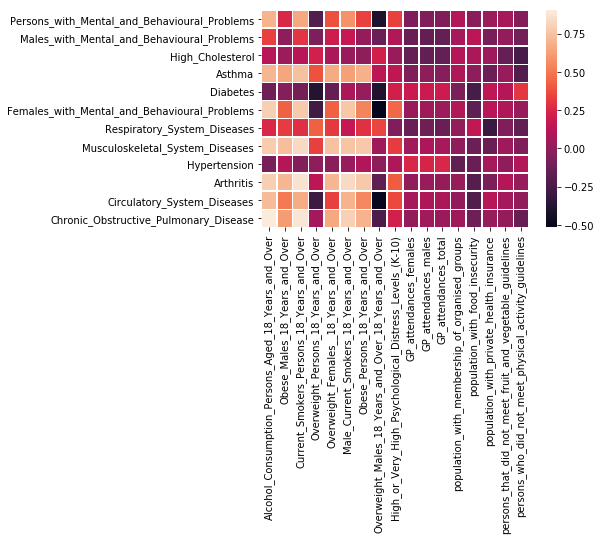

In [41]:
plt.figure()
sns.heatmap(disease_health_risk_merged_calculated, linewidths=.5)
save = "plot/disease_risk_health_risk_heat_map.png"
plt.savefig(save)
plt.show()

# linear regression

## regression function

In [42]:
from sklearn.linear_model import LinearRegression

def linear_regression(table, xcol, ycol, xaxis="", yaxis="",title=""):
    x = table[xcol]
    y = table[ycol]

    sns.regplot(x=x, y=y, marker="+")
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.savefig("plot/"+title+".png")
    plt.show()

## drinking alcohol and circulatory system disease

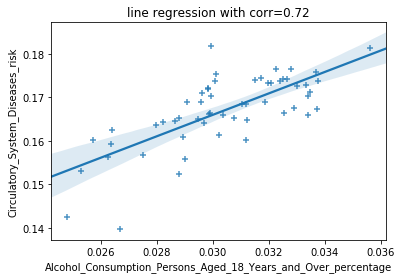

In [43]:
linear_regression(disease_health_risk_merged, 'Alcohol_Consumption_Persons_Aged_18_Years_and_Over', 'Circulatory_System_Diseases',
                 "Alcohol_Consumption_Persons_Aged_18_Years_and_Over_percentage", "Circulatory_System_Diseases_risk",
                  "line regression with corr=0.72")


## percentage of obese adults & musculoskeletal system diseases risk

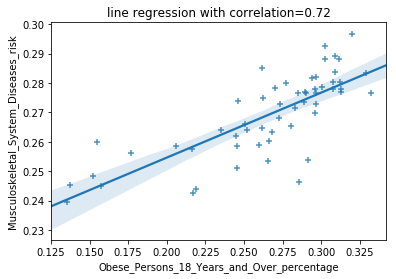

In [44]:
linear_regression(disease_health_risk_merged, 'Obese_Persons_18_Years_and_Over', 'Musculoskeletal_System_Diseases',
                 "Obese_Persons_18_Years_and_Over_percentage", 'Musculoskeletal_System_Diseases_risk',
                  "line regression with correlation=0.72")

## percentage of obese adults & arthritis

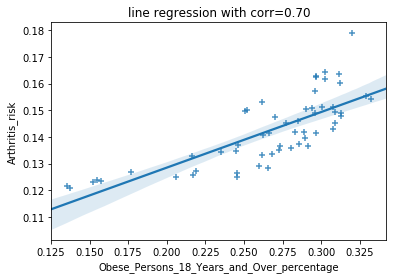

In [45]:
linear_regression(disease_health_risk_merged, 'Obese_Persons_18_Years_and_Over', 'Arthritis',
                 "Obese_Persons_18_Years_and_Over_percentage", "Arthritis_risk",
                  "line regression with corr=0.70")

## percentage of adult smokers & asthma risk

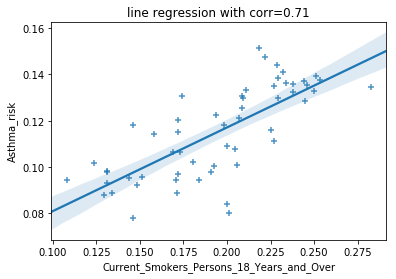

In [46]:
linear_regression(disease_health_risk_merged, 'Current_Smokers_Persons_18_Years_and_Over', 'Asthma',
                 'Current_Smokers_Persons_18_Years_and_Over', "Asthma_risk",
                  "line regression with corr=0.71")

## percentage of adult smokers & chronic obstructive pulmonary disease

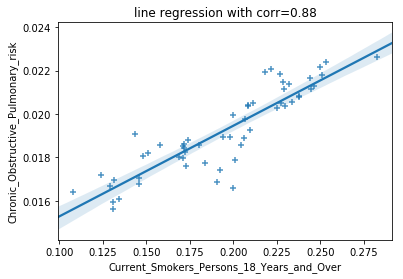

In [47]:
linear_regression(disease_health_risk_merged, 'Current_Smokers_Persons_18_Years_and_Over', 'Chronic_Obstructive_Pulmonary_Disease',
                 'Current_Smokers_Persons_18_Years_and_Over', 'Chronic_Obstructive_Pulmonary_risk',
                  "line regression with corr=0.88")

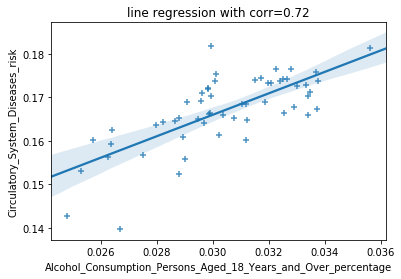

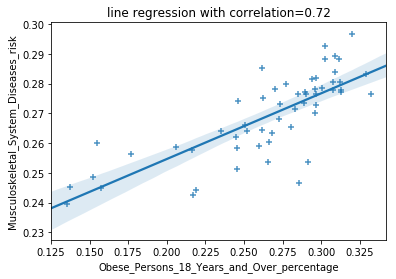

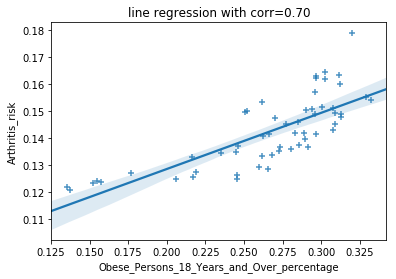

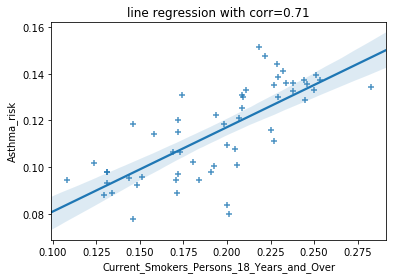

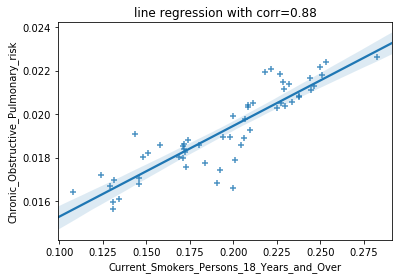

In [48]:
# linear regression

## regression function

from sklearn.linear_model import LinearRegression

def linear_regression(table, xcol, ycol, xaxis="", yaxis="",title=""):
    x = table[xcol]
    y = table[ycol]

    sns.regplot(x=x, y=y, marker="+")
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.title(title)
    plt.savefig("plot/"+title+".png")
    plt.show()

## drinking alcohol and circulatory system disease

linear_regression(disease_health_risk_merged, 'Alcohol_Consumption_Persons_Aged_18_Years_and_Over', 'Circulatory_System_Diseases',
                 "Alcohol_Consumption_Persons_Aged_18_Years_and_Over_percentage", "Circulatory_System_Diseases_risk",
                  "line regression with corr=0.72")


## percentage of obese adults & musculoskeletal system diseases risk

linear_regression(disease_health_risk_merged, 'Obese_Persons_18_Years_and_Over', 'Musculoskeletal_System_Diseases',
                 "Obese_Persons_18_Years_and_Over_percentage", 'Musculoskeletal_System_Diseases_risk',
                  "line regression with correlation=0.72")

## percentage of obese adults & arthritis

linear_regression(disease_health_risk_merged, 'Obese_Persons_18_Years_and_Over', 'Arthritis',
                 "Obese_Persons_18_Years_and_Over_percentage", "Arthritis_risk",
                  "line regression with corr=0.70")

## percentage of adult smokers & asthma risk

linear_regression(disease_health_risk_merged, 'Current_Smokers_Persons_18_Years_and_Over', 'Asthma',
                 'Current_Smokers_Persons_18_Years_and_Over', "Asthma_risk",
                  "line regression with corr=0.71")

## percentage of adult smokers & chronic obstructive pulmonary disease

linear_regression(disease_health_risk_merged, 'Current_Smokers_Persons_18_Years_and_Over', 'Chronic_Obstructive_Pulmonary_Disease',
                 'Current_Smokers_Persons_18_Years_and_Over', 'Chronic_Obstructive_Pulmonary_risk',
                  "line regression with corr=0.88")

# community feature analysis (not used in discussion)

## group by metro/rural

In [49]:
# local_governement
sorted(list(health_risk.columns))

['Alcohol_Consumption_Persons_Aged_18_Years_and_Over',
 'Current_Smokers_Persons_18_Years_and_Over',
 'Female_Current_Smokers_18_Years_and_Over',
 'GP_attendances_females',
 'GP_attendances_males',
 'GP_attendances_total',
 'High_or_Very_High_Psychological_Distress_Levels_(K-10)',
 'Local_Government_Area_Code',
 'Male_Current_Smokers_18_Years_and_Over',
 'Obese_Males_18_Years_and_Over',
 'Obese_Persons_18_Years_and_Over',
 'Overweight_Females__18_Years_and_Over',
 'Overweight_Males_18_Years_and_Over_18_Years_and_Over',
 'Overweight_Persons_18_Years_and_Over',
 'persons_that_did_not_meet_fruit_and_vegetable_guidelines',
 'persons_who_did_not_meet_physical_activity_guidelines',
 'population_with_food_insecurity',
 'population_with_membership_of_organised_groups',
 'population_with_private_health_insurance']

In [50]:
area_merged = health_risk.merge(right=lga_profile, left_on='Local_Government_Area_Code', right_on='Local_Government_Area_Code')

### parallel coordinates

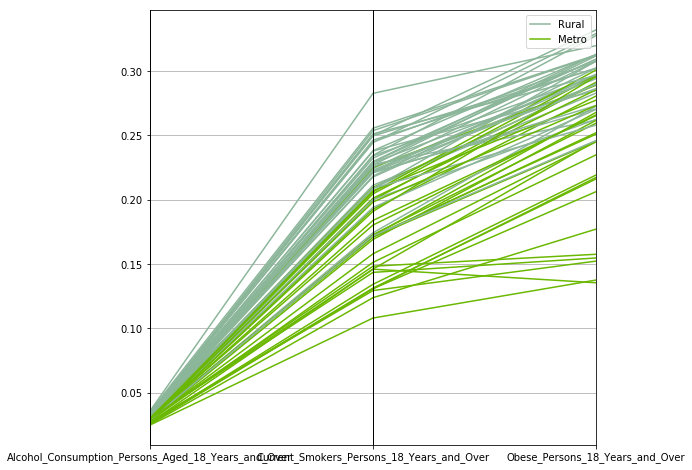

In [51]:

plt.figure(figsize=[8,8])

pc_plot(area_merged[['Alcohol_Consumption_Persons_Aged_18_Years_and_Over',
                    'Current_Smokers_Persons_18_Years_and_Over',
                    'Obese_Persons_18_Years_and_Over',
                    'Metro/rural']], 'Metro/rural')

plt.show()

# pca analysis & K-mean clustering

In [52]:
health_disease_risk = health_risk.merge(right = disease_risk, left_on="Local_Government_Area_Code", 
                                        right_on="Local_Government_Area_Code")
# health_disease_risk

## disease reduction

In [53]:
selected_disease_risk = health_disease_risk[['Arthritis',
                                            'Asthma',
                                            'Chronic_Obstructive_Pulmonary_Disease',
                                            'Circulatory_System_Diseases',
                                            'Musculoskeletal_System_Diseases']]


sklearn_pca = sklearnPCA(n_components=1)
disease_risk_sklearn = sklearn_pca.fit_transform(selected_disease_risk)

In [54]:
variance = []
variance.append(sklearn_pca.explained_variance_ratio_)

## health risk reduction

In [55]:
selected_health_risk = health_disease_risk[['Alcohol_Consumption_Persons_Aged_18_Years_and_Over',
                                        'Current_Smokers_Persons_18_Years_and_Over',
                                        'Obese_Persons_18_Years_and_Over']]

In [56]:
health_risk_sklearn = sklearn_pca.fit_transform(selected_health_risk)

In [57]:
variance.append(sklearn_pca.explained_variance_ratio_)

In [58]:
disease = [i[0] for i in disease_risk_sklearn]
health = [i[0] for i in health_risk_sklearn]
disease = pd.Series(disease)
health = pd.Series(health)
disease_health = pd.concat([disease, health], axis=1)
disease_health.columns = ["disease_risk_reduced", "health_risk_reduced"]
# disease_health

## pca analysis plot

Variance explained by each PC [array([0.82653117]), array([0.93725733])]


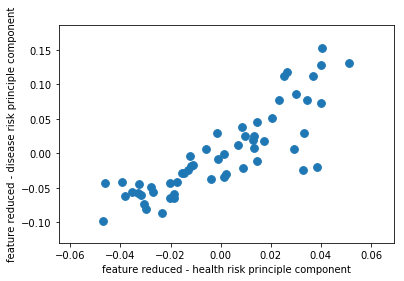

In [59]:
print("Variance explained by each PC", variance)

plt.scatter(disease_risk_sklearn, health_risk_sklearn, s=60)
plt.xlabel("feature reduced - health risk principle component")
plt.ylabel("feature reduced - disease risk principle component")
plt.show()

## k-cluster(k = 2)

In [60]:
num_clusters = 2

y_pred = KMeans(n_clusters=num_clusters).fit_predict(disease_health)

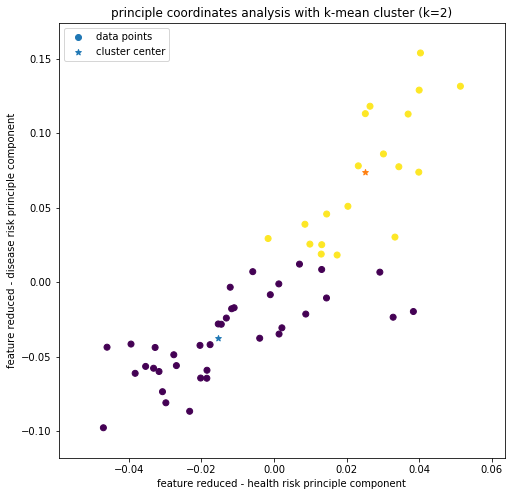

In [61]:
disease_health["cluster"] = 0

plt.figure(figsize = [8, 8])

plt.scatter(disease_health.iloc[:, 0], disease_health.iloc[:, 1], c=y_pred)

# clusterig data
for i, value in enumerate(y_pred):
    disease_health.loc[i, "cluster"] = value

# plot cluster center
for i, grouped in disease_health.groupby("cluster"):
    x_mean = grouped.iloc[:, 0].median()
    y_mean = grouped.iloc[:, 1].median()
    plt.scatter(x_mean, y_mean, marker = '*')

plt.title("principle coordinates analysis with k-mean cluster (k={})".format(num_clusters))
plt.xlabel("feature reduced - health risk principle component")
plt.ylabel("feature reduced - disease risk principle component")
plt.legend(["data points", "cluster center"])
plt.show()

# clustered community feature analysis

## community population size

In [62]:
total_population = df()

In [63]:
total_population["population"] = lga_profile['ERP_2010__Females_Total'] + lga_profile['ERP_2010__Males_Total']

## get community feature df()

In [64]:
community_feature = df()
community_feature['Unemployment_rate'] = lga_profile['Unemployment_rate'] /100
community_feature['%Born_overseas'] = lga_profile['%Born_overseas']
community_feature['%_persons_that_did_not_meet_fruit_and_vegetable_guidelines'] = lga_profile['%_persons_that_did_not_meet_fruit_and_vegetable_guidelines'] / 100
community_feature['%_persons_who_did_not_meet_physical_activity_guidelines'] =lga_profile['%_persons_who_did_not_meet_physical_activity_guidelines'] / 100

In [65]:
community_feature["high_mental_pressure"] = health_risk["High_or_Very_High_Psychological_Distress_Levels_(K-10)"]
community_feature['cluster'] = disease_health["cluster"]

In [66]:
community_feature = community_feature.dropna(axis = 0)
community_feature["population"] = total_population["population"]
community_feature['Local_Government_Area_Code'] = local_governement['Local_Government_Area_Code']

## set index df(community_feature)

In [67]:
community_feature.set_index('Local_Government_Area_Code', inplace=True)

## cluster compare and high risk community

high risk lga:
0             Bass Coast 
1                Bayside 
2                  Casey 
3     Greater Shepparton 
4                Hepburn 
5                Horsham 
6                   Hume 
7               Kingston 
8                 Loddon 
9              Glen Eira 
10             Mansfield 
11             Maroondah 
12                Melton 
13               Mildura 
14              Mitchell 
15                 Moira 
16              Moreland 
Name: name, dtype: object


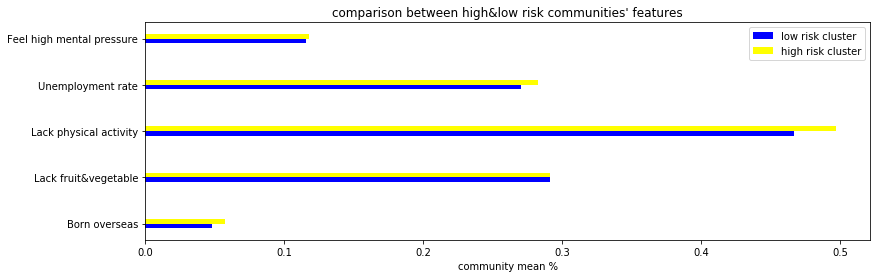

In [68]:
mean = df()

for i, group in community_feature.groupby("cluster"):
    for string in group.columns:
        if string not in ['Local_Government_Area_Code', 'cluster', 'population']:
            mean.loc[i, string+"_mean"] = sum(group[string] * group["population"]) / sum(group["population"])
    if i == 1: # 1= high risk cluster
        high_risk_lga = df()
        high_risk_lga["high_risk_lga_code"] = group.index
        high_risk_lga_name = high_risk_lga.merge(local_governement,
                                                 left_on = "high_risk_lga_code",
                                                 right_on = 'Local_Government_Area_Code')
        print("high risk lga:")
        print(high_risk_lga_name["name"])

save = "plot\community feature.png"

mean.columns = ['Born overseas',
                 'Lack fruit&vegetable',
                 'Lack physical activity',
                 'Unemployment rate',
                 'Feel high mental pressure']

transposed = mean.transpose()

plt.figure()

transposed.plot.barh(figsize=(13, 4), fontsize=10, width = 0.2, color=['blue', 'yellow'])

plt.legend(["low risk cluster", "high risk cluster"])
plt.xlabel("community mean %")
plt.title("comparison between high&low risk communities' features")

plt.savefig(save)
plt.show()

# COMP20008 Phase3 Code 904904